In [18]:
import numpy as np
from scipy import *
from scipy import sparse
from scipy.sparse.linalg import spsolve
from matplotlib.pyplot import *
import h5py
from Data_Core.experiment import *
from Data_Core.digital_twin import *
from Data_Core.fft_analysis import *
from Data_Core.visual_interface import standard_analysis
from tqdm import tqdm

# Import Data

In [2]:
def read_data_map(file):

    hf = h5py.File(file, 'r')
    sample = file.split("\\")[-1]
    keys = [key for key in hf.keys()]
    sample = keys[0].split(' ')[-1]

    spectrums = np.array([np.ndarray.flatten(np.array(list(hf['Sample_ID: ' + sample]['Spot_' + str(i)]['Shot_0']['raw_spectrum']))) for i in range(0,
                                                        len(list(hf['Sample_ID: ' + sample])))])
    positions = np.array([np.ndarray.flatten(np.array(list(hf['Sample_ID: ' + sample]['Spot_' + str(i)]['position']))) for i in range(0,
                                                        len(list(hf['Sample_ID: ' + sample])))])
    wavelengths = np.array(hf['System properties']['wavelengths'])
        
    unique_x = np.unique(positions[:,0])
    unique_y = np.unique(positions[:,1])
    
    nx = len(unique_x)
    ny = len(unique_y)
    indexes = np.lexsort((positions[:, 0],positions[:, 1]))
    spectrums = spectrums[indexes, :]
    spectrums = np.array(spectrums.reshape((ny, nx, -1)))
    # print(spectrums.shape)
    positions = np.array(positions[indexes])
    
    hf.close()
    return spectrums, wavelengths, positions, unique_x, unique_y

In [3]:
def process_chunk(chunk):
    # Apply the baseline removal to each slice in the chunk
    return np.apply_along_axis(baseline_als_optimized, 0, chunk)

def baseline_als_optimized(y, lam, p, niter = 10):
    L = len(y)
    D = sparse.diags([1, -2, 1],[0, -1, -2], shape = (L, L - 2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1 - p) * (y < z)
    return y - z

%matplotlib widget
ix, iy = 10, 10
##optimize parameters
lam = 1e2
# lam = 100000
p = 1e-4
# p = 0.05

In [4]:
file = r'D:/Data/Data_LIBS/Vidros/Areias/abran.h5'
spectrums, wavelengths, positions, unique_x, unique_y = read_data_map(file)

In [5]:
pro_data = np.array(spectrums)

for i in tqdm(range(0, pro_data.shape[0])):
    for j in range(0, pro_data.shape[1]):
        spec = 1 * pro_data[i, j, :]
        pro_data[i, j, :] = spec - baseline_als_optimized(spec, lam = lam, p = p, niter = 10)

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [02:21<00:00,  4.73s/it]


In [6]:
wavelengths = wavelengths.flatten()

In [7]:
mean_signal = np.mean(spectrums, axis = (0, 1))
min_signal = np.min(spectrums, axis = (0, 1))
max_signal = np.max(spectrums, axis = (0, 1))

# Interface

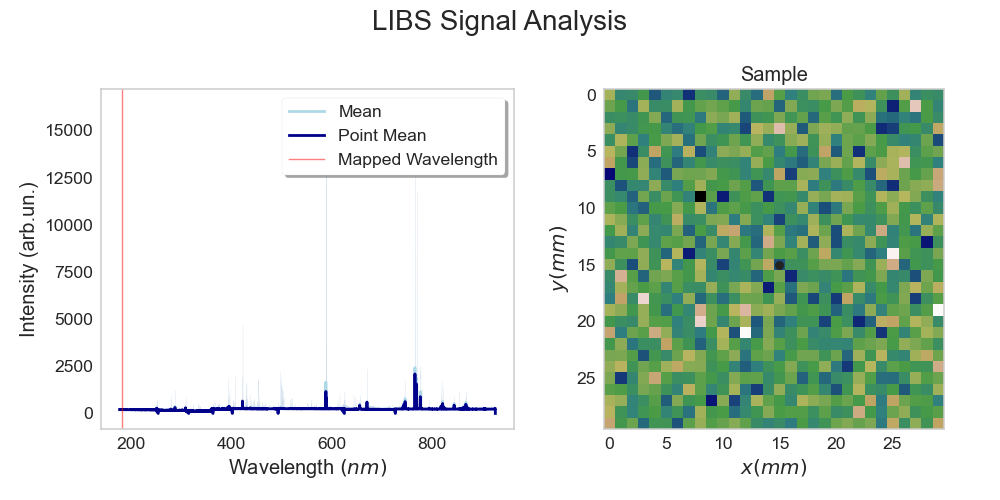

In [19]:
%matplotlib widget
standard_analysis(spectrums, wavelengths)